# Regression Model using the pooled_token from BERT

In [28]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')
import numpy as np
import statistics
# roughly following the docs here: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
%run -i ./Model_Eval.ipynb

## Load processed data

In [2]:
one_star_reviews = pd.read_csv("../Training_Data/one_star_reviews_balanced.csv")

In [3]:
x, y = one_star_reviews['full_text'].values, one_star_reviews['reviewer_avg_rating'].values

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.33, random_state=42)

In [5]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

In [6]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

2023-02-06 21:59:34.630890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 21:59:34.639195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 21:59:34.639776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 21:59:34.640421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [8]:
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # process for bert
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder') # FREEZE for now
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output'] # this is a tensor, single token representation of the sequence.
    
    net = tf.keras.layers.Dense(200, activation='relu')(net)
    net = tf.keras.layers.Dense(200, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    
    regression = tf.keras.layers.Dense(1, activation='linear', name='prediction_layer')(net)
    
    regression_model = tf.keras.Model(inputs=text_input, outputs=regression)
    
    regression_model.compile(optimizer='adam', loss='mean_squared_error')
    
    return regression_model
    

In [9]:
classifier_model = build_model()

In [10]:
type(X_train[0]) == str

True

In [11]:
# look at variance of training set
statistics.variance(Y_train)

1.1143282376765897

In [12]:
history = classifier_model.fit(
    X_train,
    Y_train,
    batch_size=20,
    validation_data=(X_test, Y_test),
    epochs=5
)

Epoch 1/5


2023-02-06 22:00:02.351612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 22:00:02.612282: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2f9f63d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-06 22:00:02.612339: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-02-06 22:00:02.617251: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-06 22:00:02.720970: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-06 22:00:02.751073: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once f

35052/35052 [==============================] - 9719s 277ms/step - loss: 1.1247 - val_loss: 1.0945
Epoch 2/5
35052/35052 [==============================] - 8471s 242ms/step - loss: 1.1039 - val_loss: 1.1026
Epoch 3/5
35052/35052 [==============================] - 7292s 208ms/step - loss: 1.0991 - val_loss: 1.1093
Epoch 4/5
35052/35052 [==============================] - 7297s 208ms/step - loss: 1.0960 - val_loss: 1.0923
Epoch 5/5
35052/35052 [==============================] - 7304s 208ms/step - loss: 1.0938 - val_loss: 1.0960


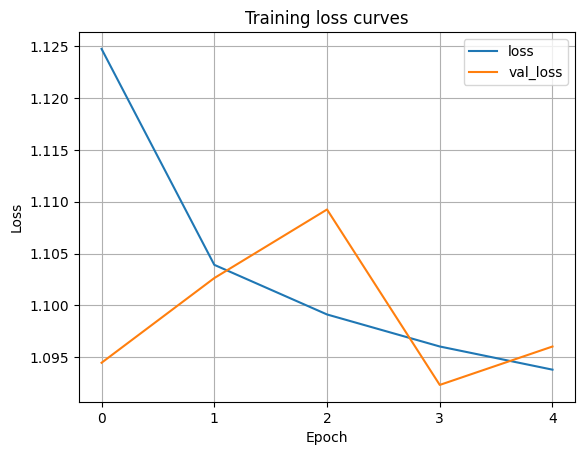

In [29]:
plot_loss(history)

## The model only performs marginally better than the mean (variance was 1.114, best loss was ~1.09)
## That is roughly an R2 score of 0.014, so the model only explains 1.4% of the variance of the dataset

In [31]:
classifier_model.save("./Saved_Models/bert_pooleld_output_NN")